In [34]:
import kagglehub
import pandas as pd
import os
from glob import glob
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification , pipeline
from datasets import Dataset
import matplotlib.pyplot as plt
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())

CUDA available: True
Device count: 1


# LOAD DATASET

In [35]:
custom_dir = "../datasets"  
os.environ["KAGGLEHUB_CACHE"] = custom_dir
path = kagglehub.dataset_download("debasisdotcom/name-entity-recognition-ner-dataset")
print("Path to dataset files:", path)

Path to dataset files: ../datasets\datasets\debasisdotcom\name-entity-recognition-ner-dataset\versions\1


In [36]:
dataset = pd.read_csv(
    '../datasets/datasets/debasisdotcom/name-entity-recognition-ner-dataset/versions/1/NER dataset.csv',
    encoding='latin-1'
)
dataset = dataset.ffill()
dataset.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


## PREPROCESS DATASET

In [37]:
dataset.columns = dataset.columns.str.strip()

# Drop rows with missing Word
dataset = dataset.dropna(subset=['Word'])

# Group by sentence
grouped = dataset.groupby('Sentence #')
sentences = [group['Word'].tolist() for _, group in grouped]
labels = [group['Tag'].tolist() for _, group in grouped]

print(f"Total sentences: {len(sentences)}")
print("Example:", list(zip(sentences[0], labels[0])))

Total sentences: 47959
Example: [('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [38]:
raw_dataset = Dataset.from_dict({
    "tokens": sentences,
    "ner_tags": labels
})

In [39]:
all_unique_tags = sorted(set(tag for sent_tags in labels for tag in sent_tags))
print("NER Tags:", all_unique_tags)

label_to_id = {tag: i for i, tag in enumerate(all_unique_tags)}
id_to_label = {i: tag for tag, i in label_to_id.items()}
num_labels = len(all_unique_tags)

NER Tags: ['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve', 'I-geo', 'I-gpe', 'I-nat', 'I-org', 'I-per', 'I-tim', 'O']


## FINETUNE ENCODER MODEL

In [40]:
model_name = "bert-base-cased"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)
print(tokenizer)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [41]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding=True,
        is_split_into_words=True,  
        max_length=128,
        return_tensors="pt"
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100) 
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])  
            else:
                label_ids.append(-100) 
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = raw_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_dataset.column_names 
)

print(tokenized_dataset[0].keys())
# ['input_ids', 'attention_mask', 'labels']

Map: 100%|██████████| 47959/47959 [00:16<00:00, 2985.65 examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [42]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

In [43]:
example = train_dataset[0]
print("Input IDs:", example["input_ids"][:10])
print("Tokens   :", tokenizer.convert_ids_to_tokens(example["input_ids"][:10]))
print("Labels   :", example["labels"][:10])
print("Real tags:", [id_to_label.get(l, "IGNORE") for l in example["labels"][:10] if l != -100])

Input IDs: [101, 1230, 3143, 1106, 2733, 2502, 1112, 4125, 1206, 4116]
Tokens   : ['[CLS]', 'His', 'visit', 'to', 'Russia', 'comes', 'as', 'relations', 'between', 'Moscow']
Labels   : [-100, 16, 16, 16, 2, 16, 16, 16, 16, 2]
Real tags: ['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'B-geo']


In [ ]:
training_args = TrainingArguments(
    output_dir="../models/ner-model",
    eval_strategy="epoch", 
    logging_strategy="epoch",      
    learning_rate=2e-5,
    per_device_train_batch_size=16,     
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
    fp16=torch.cuda.is_available(),     
    report_to="none",      
    save_strategy="epoch", 
    save_total_limit=1 ,
    early_stopping_patience=3,      
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

D:\luanjiedong\AppData\Local\Temp\3\ipykernel_19428\2263966361.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.036200,0.107405
2,0.023300,0.118423
3,0.016300,0.129470
4,0.012600,0.143975
5,0.011100,0.148021


TrainOutput(global_step=11990, training_loss=0.019879683461956822, metrics={'train_runtime': 741.7709, 'train_samples_per_second': 258.618, 'train_steps_per_second': 16.164, 'total_flos': 9716036909361792.0, 'train_loss': 0.019879683461956822, 'epoch': 5.0})

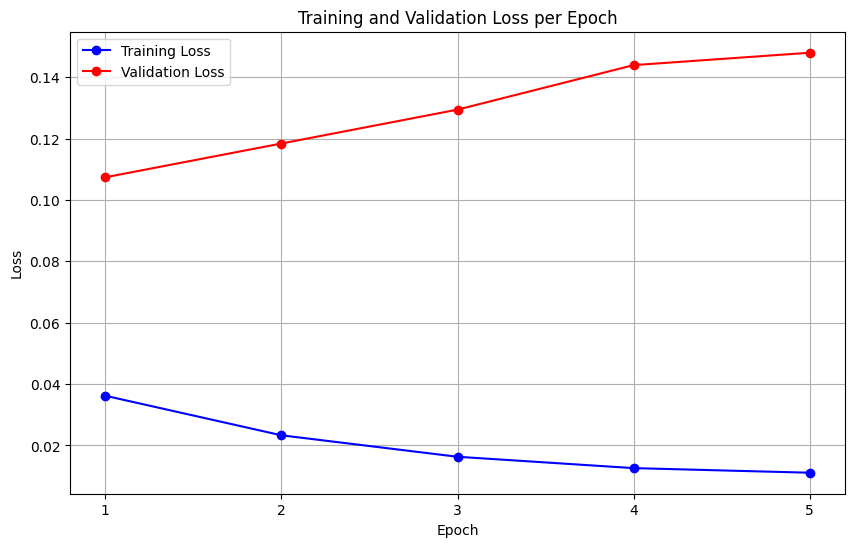

In [64]:
epochs = []
train_loss = []
eval_loss = []

logs = trainer.state.log_history
for log in logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    elif 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(epochs, eval_loss, label="Validation Loss", color="red", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.xticks(epochs)  
plt.show()

## TEST MODEL

In [54]:
ner_pipeline = pipeline(
    "token-classification",
    model="../models/ner-model/checkpoint-11990",          
    tokenizer="../models/ner-model/checkpoint-11990",      
    aggregation_strategy="simple"  
)

text = """
In a 2004 book, The Games Do Count: America's Best and Brightest on the Power of Sports, Trump claimed to have hit 
"the winning home run" when his school played Cornwall High School in 1964, garnering a headline "Trump Homers to Win the Game" in a local newspaper.
Years later, a journalist discovered that Trump's high school did not play Cornwall that year, nor did any such local headline surface.
A classmate recalled a separate incident in high school in which Trump had hit "a blooper the fielders misplayed", sending the ball "just over the third baseman's head", 
yet Trump insisted to him: "I want you to remember this: I hit the ball out of the ballpark!
"""
results = ner_pipeline(text)

for entity in results:
    print(f"Word: {entity['word']}, Entity: {entity['entity_group']}, Score: {entity['score']:.4f}")

Device set to use cuda:0


Word: 2004, Entity: tim, Score: 0.9998
Word: America, Entity: geo, Score: 0.4880
Word: Best and Brightest, Entity: org, Score: 0.7941
Word: Power of Sports, Entity: org, Score: 0.9993
Word: Trump, Entity: per, Score: 0.9998
Word: Cornwall, Entity: geo, Score: 0.9434
Word: High School, Entity: org, Score: 0.7434
Word: 1964, Entity: tim, Score: 0.9999
Word: Trump Homer, Entity: per, Score: 0.7336
Word: Trump, Entity: per, Score: 0.9999
Word: Cornwall, Entity: geo, Score: 0.5101
Word: that, Entity: tim, Score: 0.6216
Word: Trump, Entity: per, Score: 0.9998
Word: Trump, Entity: per, Score: 0.9998
